<a href="https://colab.research.google.com/github/NatSatie/mc886_projetos/blob/main/rascunhoTrabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Machine Learning MC886/MO444
### University of Campinas (UNICAMP), Institute of Computing (IC)

### Prof. Marcelo Reis, 2022s1

This project is under [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html)

# How to download dataset

To download and run this notebook create a [Kaggle](https://www.kaggle.com/) account, once created go to `Account` and get an API token and download as `kaggle.json`.




In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes


In [6]:
!kaggle datasets download -d "misrakahmed/vegetable-image-dataset"

100% 532M/534M [00:05<00:00, 113MB/s] 
100% 534M/534M [00:05<00:00, 95.5MB/s]


In [7]:
!unzip -qq vegetable-image-dataset.zip

# Pre-processing

In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, MobileNet, ResNet50
import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [9]:
train_path = "../content/Vegetable Images/train"
validation_path = "../content/Vegetable Images/train"
test_path = "../content/Vegetable Images/train"

image_categories = os.listdir(train_path)

# Image size default for 224 x 224, because of VG16, a convolutional neural network used in this experiment

image_value = 224
image_size=(image_value, image_value)
image_shape=(image_value, image_value, 3)
input_shape= [image_value, image_value, 3]

img_gen = ImageDataGenerator(
                                rescale = 1.0/255.0,
                                rotation_range=40,
                                horizontal_flip=True,
                                zoom_range=0.2,
                               )

train_image_generator = img_gen.flow_from_directory(
                                            train_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


val_image_generator = img_gen.flow_from_directory(
                                            validation_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


test_image_generator = img_gen.flow_from_directory(
                                            test_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.


In [10]:
img_gen_augmented = ImageDataGenerator(
                                rescale = 1.0/255.0,
                                rotation_range=40,
                                horizontal_flip=True,
                                zoom_range=0.2,
                               )

train_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            train_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


val_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            validation_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


test_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            test_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.


In [11]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/image/rotate

In [12]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# Basic functions

List of most common fuctions used in this project, such as plot accuracy, plot loss and plot convolutional network.

In [13]:
def plotAccuracy(hist, activation):
    h = hist.history
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
    plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
    plt.xlabel("Number of Epochs")
    plt.legend(loc='best')
    plt.title("Modelo de treinamento com {} ".format(activation))
    plt.show()


def plotLoss(hist, activation):
    h = hist.history
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(h['loss'], c='red', label='Training Loss')
    plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.legend(loc='best')
    plt.title("Modelo de treinamento com {} ".format(activation))
    plt.show()

def plotHistory(hist, activation):
    plotAccuracy(hist, activation)
    plotLoss(hist, activation)

In [14]:
epochs = 20

def train_model(model, optimizer, name, train_data):
  callbacks = [ keras.callbacks.EarlyStopping(patience=10),
                keras.callbacks.ModelCheckpoint('model_'+name+'.h5', 
                                                monitor='val_loss', 
                                                save_best_only=True),]
  if (optimizer == 'SGD'):
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
  else:
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
  hist = model.fit(train_data, 
                  epochs=epochs, 
                  verbose=1, 
                  validation_data=val_image_generator, 
                  steps_per_epoch = 15000//32, 
                  validation_steps = 3000//32, 
                  callbacks=callbacks)
  return model, hist

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotConfusionMatrix(model, data_test, predicted_data, title):
  y_model = np.argmax(predicted_data,axis=1)
  conf=confusion_matrix(data_test.labels, y_model)
  disp = ConfusionMatrixDisplay(conf)
  fig, ax = plt.subplots(figsize=(12, 12))
  disp.plot(ax=ax)
  plt.title(title)
  plt.show()

# Data Visualization

In [16]:
def plot_images(image_categories):
  plt.figure(figsize=(12, 12))
  for i, cat in enumerate(image_categories):
    image_path = train_path + '/' + cat
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[0]
    first_image_path = image_path + '/' + first_image_of_folder
    img = image.load_img(first_image_path)
    img_arr = image.img_to_array(img)/255.0
    plt.subplot(4, 4, i+1)
    plt.imshow(img_arr)
    plt.title(cat)
    plt.axis('off')
  plt.show()


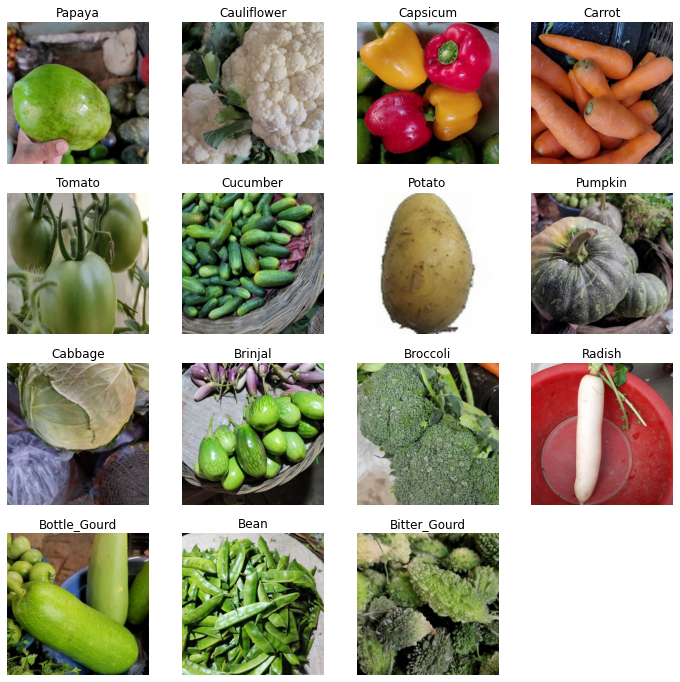

In [17]:
plot_images(image_categories)

# First Training

This is a sequence of many training with various convolutional neural network architectures, the first is a sketch of a simple CNN model, but later on it's used architectures such as InceptionV3, VGG16, ResNet and MobileNet.

In [18]:
def cnn_simple_model():
    model = Sequential([
      Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=126, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.25),
      Dense(15, activation='softmax')
    ])
    return model

model_cnn = cnn_simple_model()

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 126)       72702     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 126)      0

In [19]:
model_cnn, hist_cnn = train_model(cnn_simple_model(), 'SGD', 'cnn', train_image_generator)

Epoch 1/20
468/468 [==============================] - 245s 500ms/step - loss: 2.1751 - accuracy: 0.2702 - val_loss: 2.3086 - val_accuracy: 0.2540
Epoch 2/20
468/468 [==============================] - 235s 501ms/step - loss: 1.5463 - accuracy: 0.4794 - val_loss: 1.1705 - val_accuracy: 0.5971
Epoch 3/20
468/468 [==============================] - 231s 493ms/step - loss: 1.2292 - accuracy: 0.5897 - val_loss: 0.8976 - val_accuracy: 0.7056
Epoch 4/20
468/468 [==============================] - 231s 494ms/step - loss: 0.9431 - accuracy: 0.6855 - val_loss: 0.6376 - val_accuracy: 0.7970
Epoch 5/20
468/468 [==============================] - 236s 504ms/step - loss: 0.7298 - accuracy: 0.7620 - val_loss: 0.5270 - val_accuracy: 0.8370
Epoch 6/20
468/468 [==============================] - 232s 496ms/step - loss: 0.5258 - accuracy: 0.8316 - val_loss: 0.3534 - val_accuracy: 0.8911
Epoch 7/20
468/468 [==============================] - 232s 495ms/step - loss: 0.4408 - accuracy: 0.8658 - val_loss: 0.3224 -

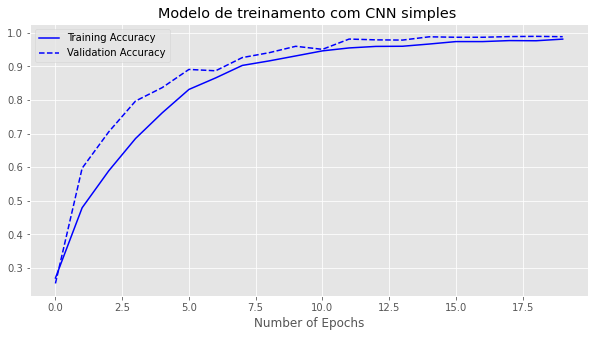

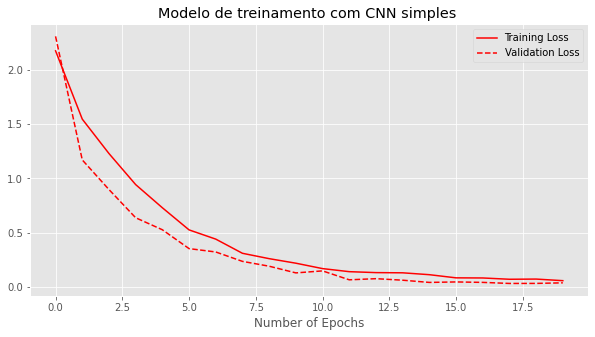

In [20]:
plotHistory(hist_cnn, "CNN simples")

In [21]:
model_cnn_augmented, hist_cnn_augmented = train_model(cnn_simple_model(), 'SGD', 'cnn_augmented', train_image_generator_augmented)

Epoch 1/20
468/468 [==============================] - 231s 491ms/step - loss: 2.1607 - accuracy: 0.2769 - val_loss: 1.7090 - val_accuracy: 0.4002
Epoch 2/20
468/468 [==============================] - 233s 498ms/step - loss: 1.5045 - accuracy: 0.4918 - val_loss: 1.1477 - val_accuracy: 0.6364
Epoch 3/20
468/468 [==============================] - 229s 488ms/step - loss: 1.1245 - accuracy: 0.6237 - val_loss: 0.8375 - val_accuracy: 0.7466
Epoch 4/20
468/468 [==============================] - 229s 490ms/step - loss: 0.8453 - accuracy: 0.7205 - val_loss: 0.6249 - val_accuracy: 0.7886
Epoch 5/20
468/468 [==============================] - 229s 490ms/step - loss: 0.6462 - accuracy: 0.7981 - val_loss: 0.7766 - val_accuracy: 0.7339
Epoch 6/20
468/468 [==============================] - 229s 490ms/step - loss: 0.4701 - accuracy: 0.8499 - val_loss: 0.3296 - val_accuracy: 0.9036
Epoch 7/20
468/468 [==============================] - 230s 491ms/step - loss: 0.3828 - accuracy: 0.8759 - val_loss: 0.2984 -

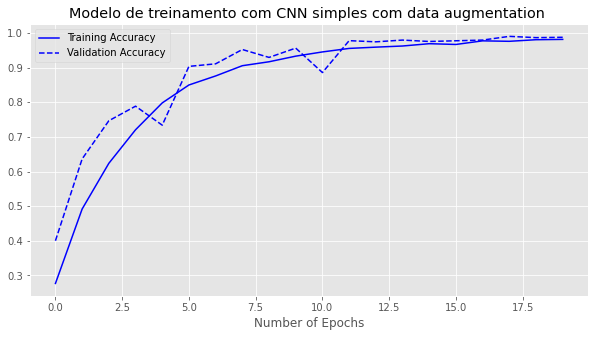

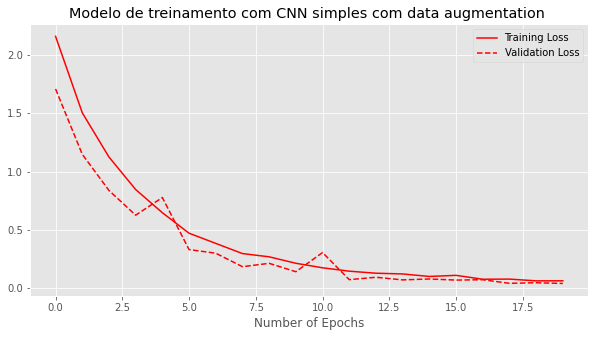

In [22]:
plotHistory(hist_cnn_augmented, "CNN simples com data augmentation")

## Inception V3

In [23]:
def cnn_transfer_learning_model(model_base):
  if (model_base=='inception'):
    pre_trained_model = InceptionV3(input_shape=image_shape, include_top = False, weights="imagenet")
  elif (model_base=='vgg16'):
    pre_trained_model = VGG16(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  elif (model_base=='mobilenet'):
    pre_trained_model = MobileNet(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  elif (model_base=='resnet'):
    pre_trained_model = ResNet50(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  model = Sequential([
      pre_trained_model,
      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.25),
      Dense(15, activation='softmax')
  ])
  return model

In [24]:
model_v3, hist_v3 = train_model(cnn_transfer_learning_model('inception')
                                            , 'SGD', 'inceptionv3', train_image_generator)

87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/20
468/468 [==============================] - 268s 555ms/step - loss: 0.2196 - accuracy: 0.9365 - val_loss: 0.0158 - val_accuracy: 0.9953
Epoch 2/20
468/468 [==============================] - 258s 551ms/step - loss: 0.0319 - accuracy: 0.9906 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 3/20
468/468 [==============================] - 258s 550ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 4/20
468/468 [==============================] - 256s 546ms/step - loss: 0.0148 - accuracy: 0.9949 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 5/20
468/468 [==============================] - 259s 552ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 5.5313e-04 - val_accuracy: 0.9997
Epoch 6/20
468/468 [==============================] - 258s 550ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 2.9612e-04 - val_accuracy: 1.0000
Epoch 7/20
468/468 [==============================]

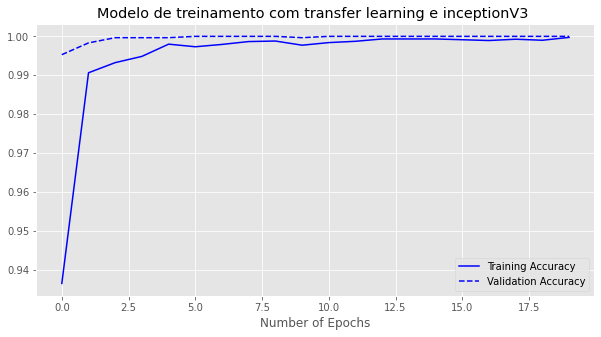

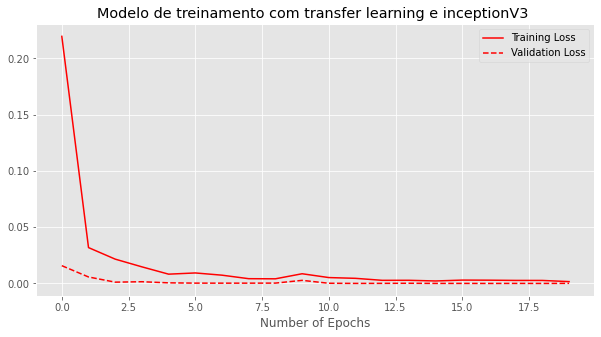

In [25]:
plotHistory(hist_v3, "transfer learning e inceptionV3")

In [26]:
model_v3_augmented, hist_v3_augmented = train_model(cnn_transfer_learning_model('inception')
                                            , 'SGD', 'inceptionv3_augmented', train_image_generator)

Epoch 1/20
468/468 [==============================] - 267s 557ms/step - loss: 0.2258 - accuracy: 0.9338 - val_loss: 0.0064 - val_accuracy: 0.9980
Epoch 2/20
468/468 [==============================] - 258s 551ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0064 - val_accuracy: 0.9983
Epoch 3/20
468/468 [==============================] - 261s 557ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 6.6046e-04 - val_accuracy: 0.9997
Epoch 4/20
468/468 [==============================] - 255s 544ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 5/20
468/468 [==============================] - 254s 544ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 2.6872e-04 - val_accuracy: 1.0000
Epoch 6/20
468/468 [==============================] - 256s 547ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 1.2572e-04 - val_accuracy: 1.0000
Epoch 7/20
468/468 [==============================] - 258s 550ms/step - loss: 0.0093 - accuracy: 0.9975 - val_lo

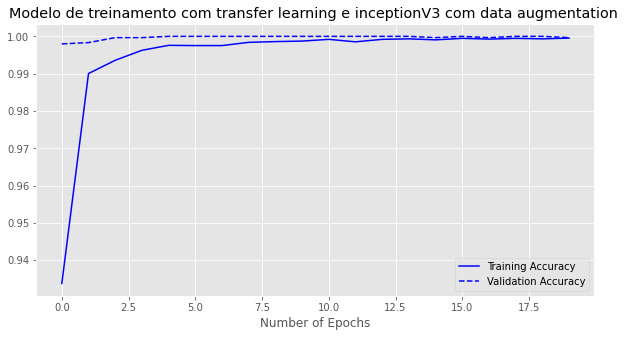

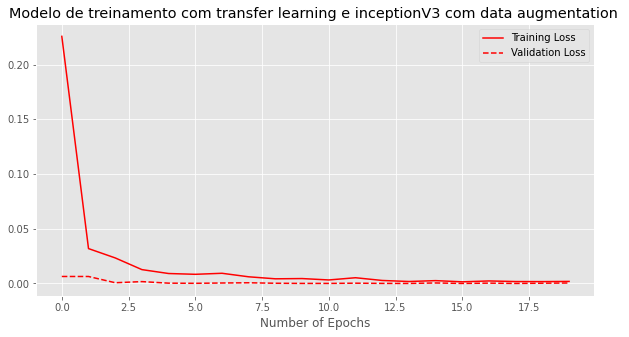

In [27]:
plotHistory(hist_v3_augmented, "transfer learning e inceptionV3 com data augmentation")

## VGG16

In [48]:
epochs = 10

In [49]:
model_vgg16, hist_vgg16 = train_model(cnn_transfer_learning_model('vgg16')
                                            , 'SGD', 'vgg16', train_image_generator)

Epoch 1/10
468/468 [==============================] - 269s 572ms/step - loss: 2.4168 - accuracy: 0.2005 - val_loss: 0.8574 - val_accuracy: 0.7191
Epoch 2/10
468/468 [==============================] - 266s 569ms/step - loss: 1.3476 - accuracy: 0.5703 - val_loss: 2.5303 - val_accuracy: 0.1697
Epoch 3/10
468/468 [==============================] - 265s 567ms/step - loss: 0.5791 - accuracy: 0.8135 - val_loss: 0.3496 - val_accuracy: 0.8921
Epoch 4/10
468/468 [==============================] - 266s 567ms/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.0338 - val_accuracy: 0.9866
Epoch 5/10
468/468 [==============================] - 266s 569ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.0129 - val_accuracy: 0.9950
Epoch 6/10
468/468 [==============================] - 267s 571ms/step - loss: 0.1883 - accuracy: 0.9481 - val_loss: 0.0355 - val_accuracy: 0.9906
Epoch 7/10
468/468 [==============================] - 266s 569ms/step - loss: 0.0452 - accuracy: 0.9874 - val_loss: 0.0951 -

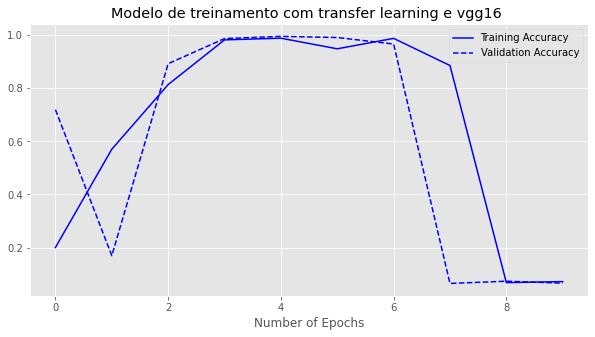

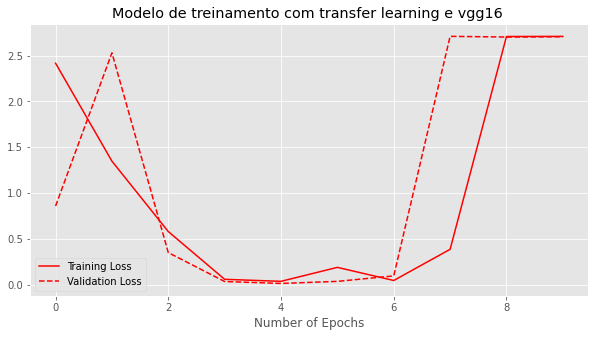

In [50]:
plotHistory(hist_vgg16, "transfer learning e vgg16")

In [ ]:
epochs = 20

In [30]:
model_vgg16_augmented, hist_vgg16_augmented = train_model(cnn_transfer_learning_model('vgg16')
                                            , 'SGD', 'vgg16_augmented', train_image_generator_augmented)

Epoch 1/20
468/468 [==============================] - 268s 571ms/step - loss: 2.4659 - accuracy: 0.1937 - val_loss: 0.8737 - val_accuracy: 0.7278
Epoch 2/20
468/468 [==============================] - 267s 570ms/step - loss: 0.3694 - accuracy: 0.8859 - val_loss: 0.0699 - val_accuracy: 0.9768
Epoch 3/20
468/468 [==============================] - 269s 574ms/step - loss: 1.6235 - accuracy: 0.4725 - val_loss: 0.2431 - val_accuracy: 0.9338
Epoch 4/20
468/468 [==============================] - 269s 575ms/step - loss: 0.2086 - accuracy: 0.9389 - val_loss: 1.2535 - val_accuracy: 0.7550
Epoch 5/20
468/468 [==============================] - 267s 571ms/step - loss: 0.1026 - accuracy: 0.9696 - val_loss: 0.0194 - val_accuracy: 0.9943
Epoch 6/20
468/468 [==============================] - 268s 574ms/step - loss: 0.0252 - accuracy: 0.9932 - val_loss: 0.0120 - val_accuracy: 0.9980
Epoch 7/20
468/468 [==============================] - 266s 568ms/step - loss: 0.4050 - accuracy: 0.8709 - val_loss: 0.0164 -

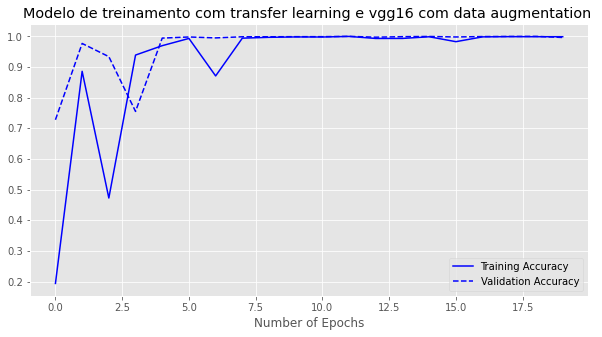

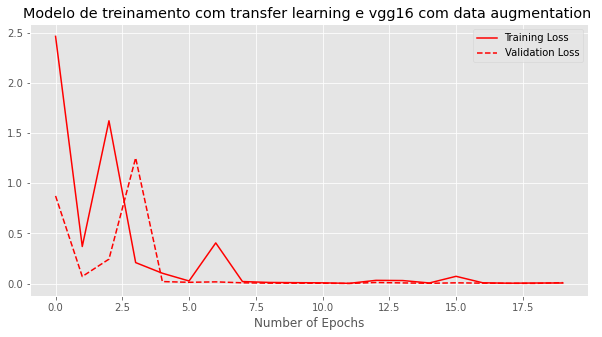

In [31]:
plotHistory(hist_vgg16_augmented, "transfer learning e vgg16 com data augmentation")

## MobileNet

In [32]:
model_mobile, hist_mobile = train_model(cnn_transfer_learning_model('mobilenet')
                                            , 'SGD', 'mobilenet', train_image_generator)

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/20
468/468 [==============================] - 259s 546ms/step - loss: 0.4758 - accuracy: 0.9399 - val_loss: 0.0146 - val_accuracy: 0.9970
Epoch 2/20
468/468 [==============================] - 251s 537ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0109 - val_accuracy: 0.9963
Epoch 3/20
468/468 [==============================] - 247s 528ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/20
468/468 [==============================] - 250s 534ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 5/20
468/468 [==============================] - 250s 533ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 4.6232e-04 - val_accuracy: 1.0000
Epoch 6/20
468/468 [==============================] - 258s 551ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 1.8828e-04 - val_accuracy: 1.0000
Epoch 7/20
468/468 [==============================]

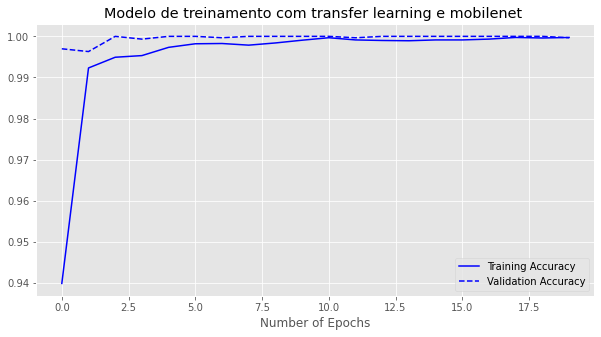

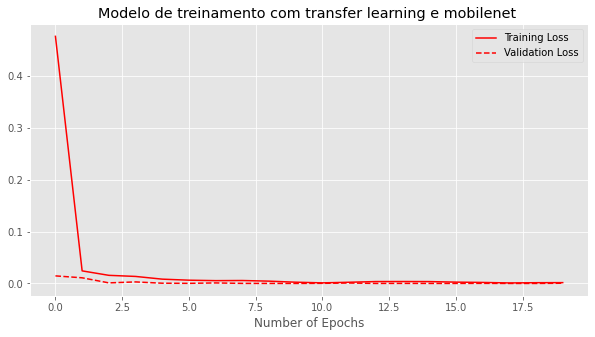

In [33]:
plotHistory(hist_mobile, "transfer learning e mobilenet")

In [34]:
model_mobile_augmented, hist_mobile_augmented = train_model(cnn_transfer_learning_model('mobilenet')
                                            , 'SGD', 'mobilenet_augmented', train_image_generator_augmented)

Epoch 1/20
468/468 [==============================] - 246s 520ms/step - loss: 0.3714 - accuracy: 0.9408 - val_loss: 0.0096 - val_accuracy: 0.9963
Epoch 2/20
468/468 [==============================] - 243s 520ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/20
468/468 [==============================] - 249s 532ms/step - loss: 0.0138 - accuracy: 0.9952 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 4/20
468/468 [==============================] - 250s 533ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 3.9816e-04 - val_accuracy: 1.0000
Epoch 5/20
468/468 [==============================] - 249s 532ms/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.0023 - val_accuracy: 0.9997
Epoch 6/20
468/468 [==============================] - 250s 534ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 3.1373e-04 - val_accuracy: 1.0000
Epoch 7/20
468/468 [==============================] - 252s 539ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 

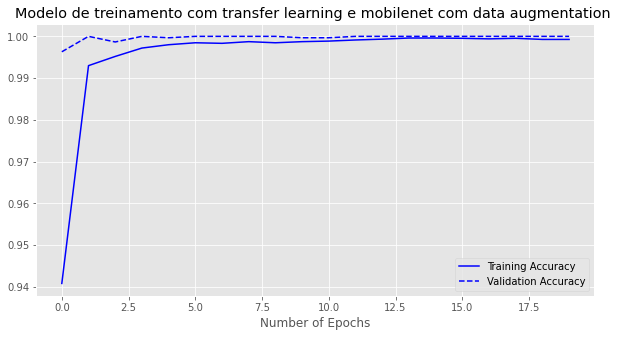

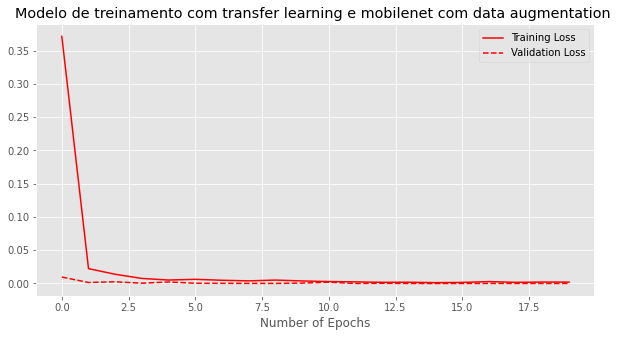

In [35]:
plotHistory(hist_mobile_augmented, "transfer learning e mobilenet com data augmentation")

## ResNet

In [36]:
model_resnet, hist_resnet = train_model(cnn_transfer_learning_model('resnet')
                                            , 'SGD', 'resnet', train_image_generator)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
468/468 [==============================] - 260s 542ms/step - loss: 0.3630 - accuracy: 0.9474 - val_loss: 4.8967 - val_accuracy: 0.0917
Epoch 2/20
468/468 [==============================] - 249s 532ms/step - loss: 0.0254 - accuracy: 0.9912 - val_loss: 0.1370 - val_accuracy: 0.9519
Epoch 3/20
468/468 [==============================] - 247s 527ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 4/20
468/468 [==============================] - 254s 542ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0078 - val_accuracy: 0.9983
Epoch 5/20
468/468 [==============================] - 259s 553ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0062 - val_accuracy: 0.9973
Epoch 6/20
468/468 [==============================] - 251s 535ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 4.3112e-04 - val_accuracy: 1.0000
Epoch 7/20
468/468 [==============================] - 2

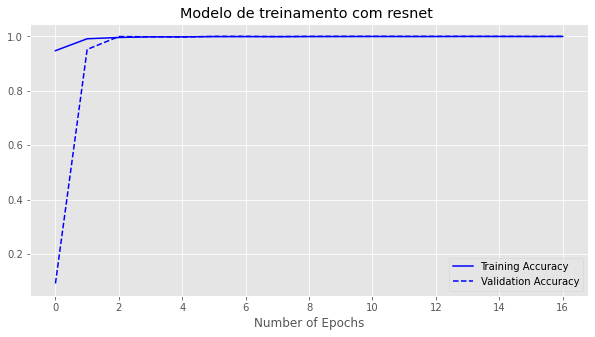

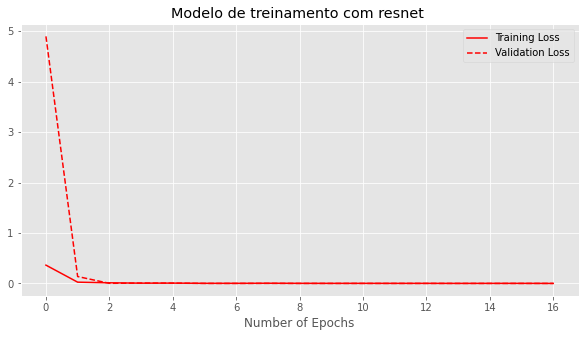

In [37]:
plotHistory(hist_resnet, "resnet")

In [38]:
model_resnet_augmented, hist_resnet_augmented = train_model(cnn_transfer_learning_model('resnet')
                                            , 'SGD', 'resnet_augmented', train_image_generator_augmented)

Epoch 1/20
468/468 [==============================] - 254s 531ms/step - loss: 0.4874 - accuracy: 0.9345 - val_loss: 10.6302 - val_accuracy: 0.0605
Epoch 2/20
468/468 [==============================] - 245s 523ms/step - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.4497 - val_accuracy: 0.8522
Epoch 3/20
468/468 [==============================] - 246s 526ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0024 - val_accuracy: 0.9990
Epoch 4/20
468/468 [==============================] - 256s 547ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9983
Epoch 5/20
468/468 [==============================] - 258s 552ms/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 2.2268e-04 - val_accuracy: 1.0000
Epoch 6/20
468/468 [==============================] - 255s 545ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 5.4721e-04 - val_accuracy: 0.9997
Epoch 7/20
468/468 [==============================] - 253s 540ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss:

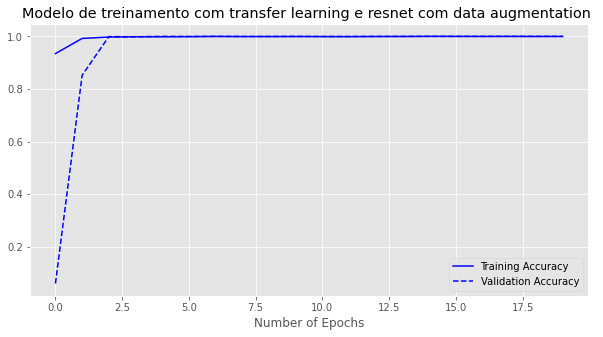

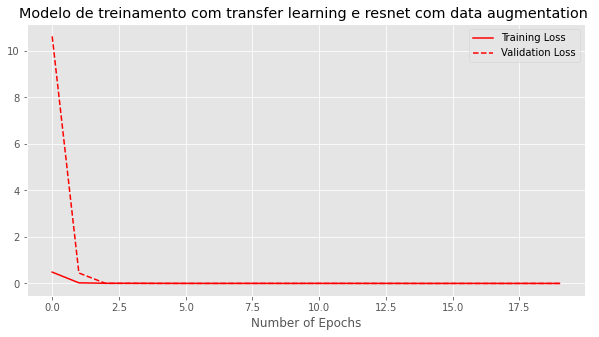

In [39]:
plotHistory(hist_resnet_augmented, "transfer learning e resnet com data augmentation")

# Analysis with confusion matrix

In [51]:
predicted_cnn = model_cnn.predict(train_image_generator)
predicted_v3 = model_v3.predict(train_image_generator)
predicted_vgg16 = model_vgg16.predict(train_image_generator)
predicted_mobile = model_mobile.predict(train_image_generator)
predicted_resnet = model_resnet.predict(train_image_generator)

In [41]:
predicted_cnn_augmented     = model_cnn_augmented.predict(train_image_generator_augmented)
predicted_v3_augmented      = model_v3_augmented.predict(train_image_generator_augmented)
predicted_vgg16_augmented   = model_vgg16_augmented.predict(train_image_generator_augmented)
predicted_mobile_augmented  = model_mobile_augmented.predict(train_image_generator_augmented)
predicted_resnet_augmented  = model_resnet_augmented.predict(train_image_generator_augmented)

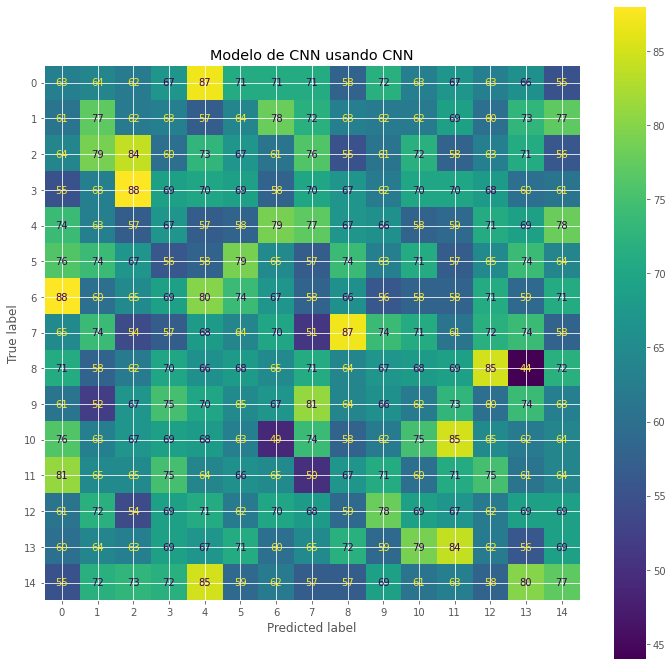

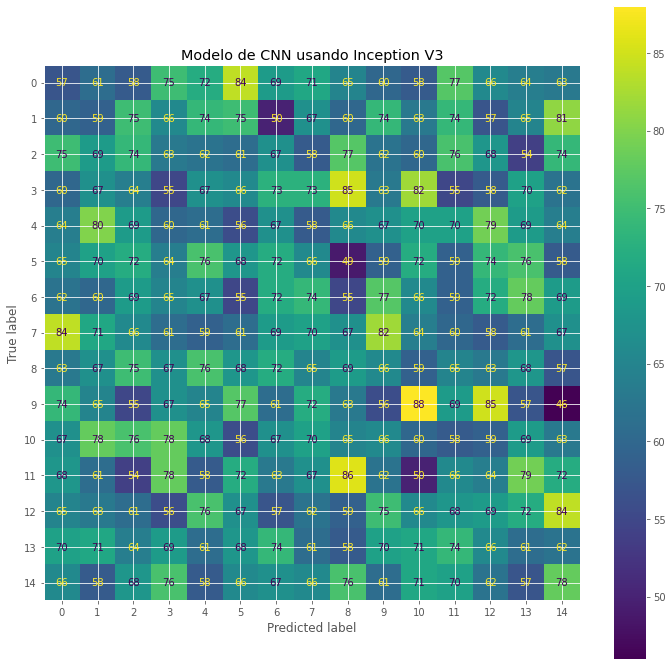

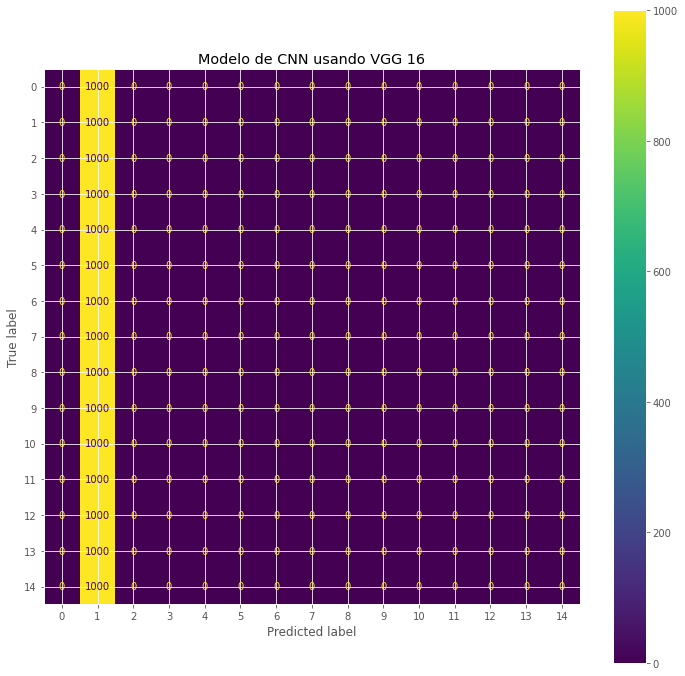

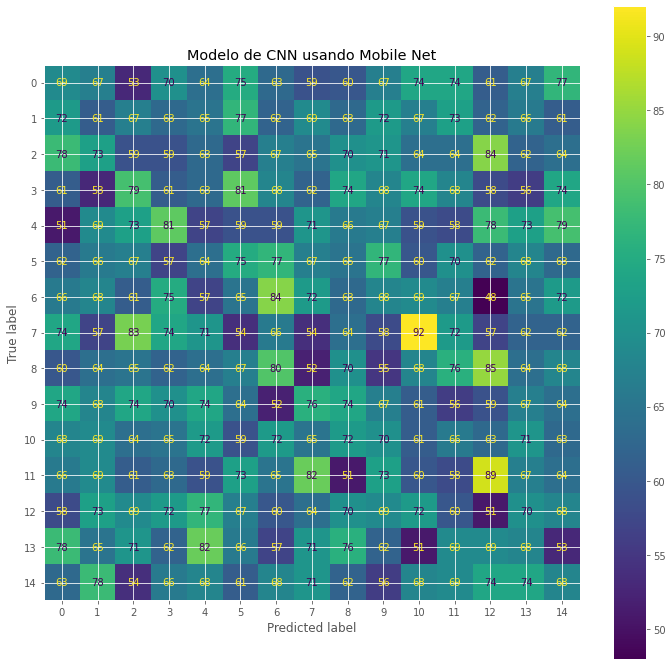

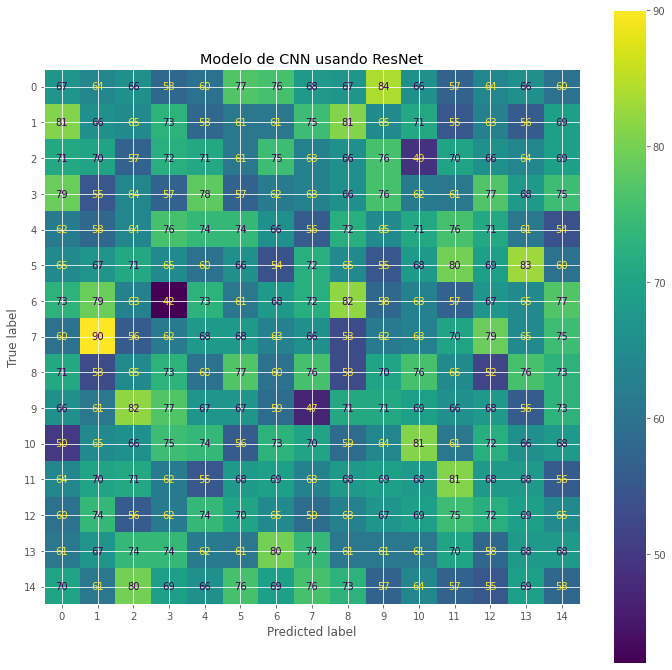

In [52]:
plotConfusionMatrix(model_cnn, train_image_generator, predicted_cnn, "Modelo de CNN usando CNN")
plotConfusionMatrix(model_v3, train_image_generator, predicted_v3, "Modelo de CNN usando Inception V3")
plotConfusionMatrix(model_vgg16, train_image_generator, predicted_vgg16, "Modelo de CNN usando VGG 16")
plotConfusionMatrix(model_mobile, train_image_generator, predicted_mobile, "Modelo de CNN usando Mobile Net")
plotConfusionMatrix(model_resnet, train_image_generator, predicted_resnet, "Modelo de CNN usando ResNet")

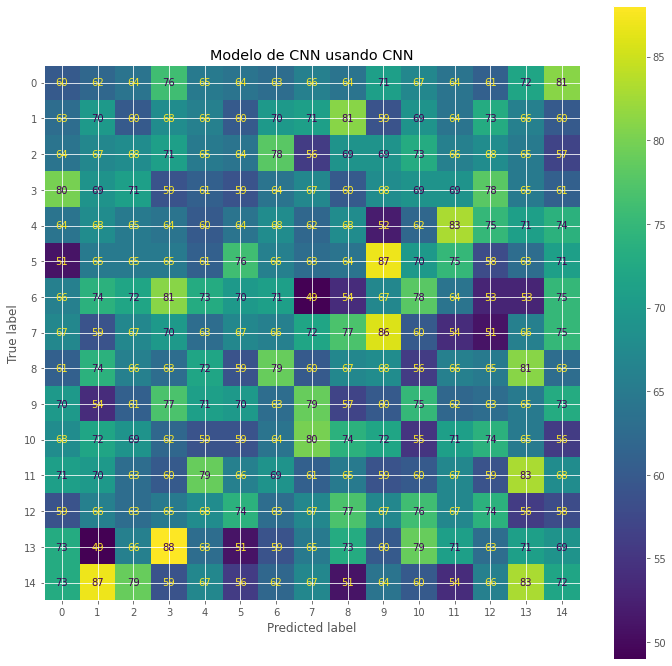

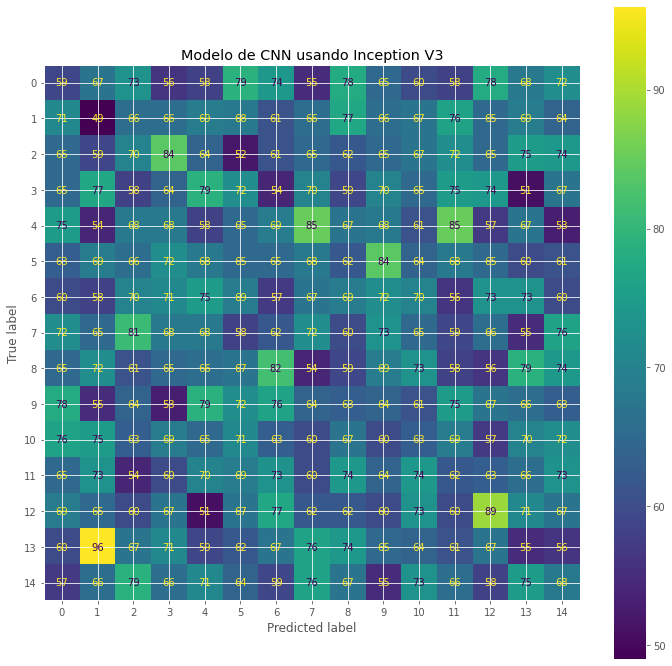

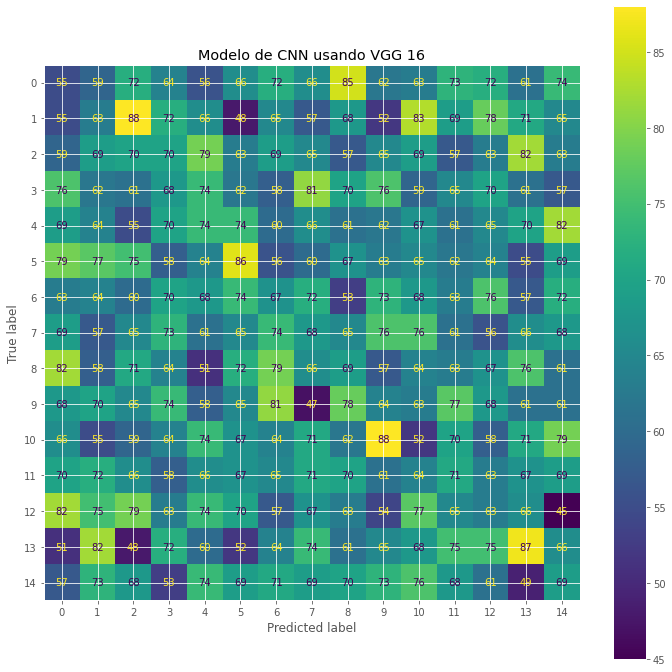

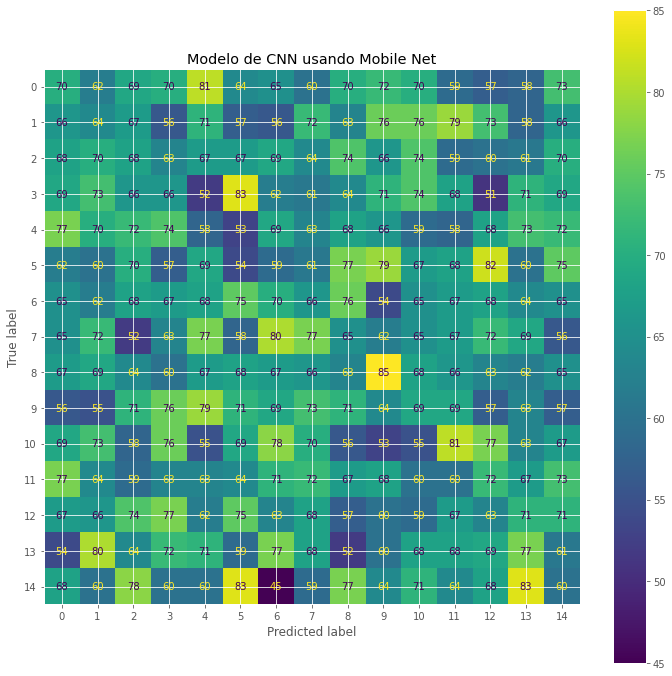

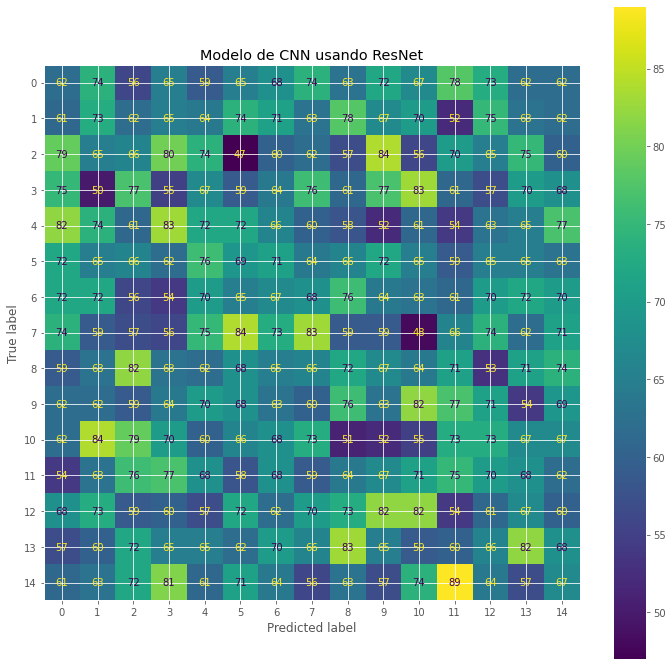

In [43]:
plotConfusionMatrix(model_cnn_augmented   , train_image_generator_augmented, predicted_cnn_augmented    , "Modelo de CNN usando CNN")
plotConfusionMatrix(model_v3_augmented    , train_image_generator_augmented, predicted_v3_augmented     , "Modelo de CNN usando Inception V3")
plotConfusionMatrix(model_vgg16_augmented , train_image_generator_augmented, predicted_vgg16_augmented  , "Modelo de CNN usando VGG 16")
plotConfusionMatrix(model_mobile_augmented, train_image_generator_augmented, predicted_mobile_augmented , "Modelo de CNN usando Mobile Net")
plotConfusionMatrix(model_resnet_augmented, train_image_generator_augmented, predicted_resnet_augmented , "Modelo de CNN usando ResNet")

# Validation

In [53]:
model_cnn.evaluate(test_image_generator)
model_v3.evaluate(test_image_generator)
model_vgg16.evaluate(test_image_generator)
model_mobile.evaluate(test_image_generator)
model_resnet.evaluate(test_image_generator)

469/469 [==============================] - 193s 411ms/step - loss: 7.8749e-04 - accuracy: 0.9995


[0.0007874940638430417, 0.9995333552360535]

In [45]:
model_cnn_augmented.evaluate(test_image_generator_augmented)
model_v3_augmented.evaluate(test_image_generator_augmented)
model_vgg16_augmented.evaluate(test_image_generator_augmented)
model_mobile_augmented.evaluate(test_image_generator_augmented)
model_resnet_augmented.evaluate(test_image_generator_augmented)

469/469 [==============================] - 192s 409ms/step - loss: 2.6258e-04 - accuracy: 0.9999


[0.0002625819470267743, 0.9998666644096375]

In [46]:
# while True:pass

KeyboardInterrupt: ignored